# Basic Home Net-Metering Example

- 8 Houses in total
- 4 with solar, 4 without
- 2 of the solar homes are considered "metered"
- These 2 homes are used as proxies and tuning systems

In this notebook, we first run dissagregation problem using the naive weights automatically instantiated by the class constructor. Then, we illustrate the impact of changing the weight of the load model. Finally, we implement Michaelangelo's _fancy_ weight tuning procedure.

In [1]:
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import pprint
import os
import matplotlib.pyplot as plt 
from csss.SolarDisagg import SolarDisagg_IndvHome, createSolarDisaggIndvInputs

### Load the data

The data file was created by running `scripts/tutorial_data_setup.py`.

In [4]:
df = pd.read_csv('data/tutorial_data.csv', index_col=0, header=[0, 1], parse_dates=[0])
df.head()

use         gen     netload       use    gen  \
                    solar_home1 solar_home1 solar_home1    proxy1 proxy1   
time                                                                       
2015-04-01 00:00:00    0.994133     -0.0040    0.998133  0.294400 -0.006   
2015-04-01 00:15:00    1.668467     -0.0040    1.672467  0.294733 -0.006   
2015-04-01 00:30:00    1.097600     -0.0040    1.101600  0.295800 -0.006   
2015-04-01 00:45:00    1.080533     -0.0040    1.084533  0.377333 -0.006   
2015-04-01 01:00:00    1.827000     -0.0038    1.830800  0.401933 -0.006   

                      netload       use   gen   netload       use  \
                       proxy1     home1 home1     home1     home2   
time                                                                
2015-04-01 00:00:00  0.300400  1.200800   0.0  1.200800  0.721200   
2015-04-01 00:15:00  0.300733  0.488400   0.0  0.488400  0.752867   
2015-04-01 00:30:00  0.301800  0.455267   0.0  0.455267  0.604533   
2015-04-01 00:45:00  0.383333  0.350267   0.0  0.350267  0.760667   
2015-04-01 01:00:00  0.407933  1.129267   0.0  1.129267  0.513467   

                            ...               gen   netload       use   gen  \
                            ...            proxy2    proxy2     home4 home4   
time                        ...                                               
2015-04-01 00:00:00         ...         -0.008000  0.616667  0.344800   0.0   
2015-04-01 00:15:00         ...         -0.007600  0.611267  0.316400   0.0   
2015-04-01 00:30:00         ...         -0.007600  0.579467  1.071733   0.0   
2015-04-01 00:45:00         ...         -0.007533  0.704533  2.797067   0.0   
2015-04-01 01:00:00         ...         -0.007067  0.597800  0.239667   0.0   

                      netload         use         gen     netload           \
                        home4 solar_home4 solar_home4 solar_home4      agg   
time                                                                         
2015-04-01 00:00:00  0.344800    0.460467   -0.007333    0.467800   7.2152   
2015-04-01 00:15:00  0.316400    0.334600   -0.007000    0.341600   6.9414   
2015-04-01 00:30:00  1.071733    0.377933   -0.007333    0.385267   7.1494   
2015-04-01 00:45:00  2.797067    0.471467   -0.008000    0.479467  10.3526   
2015-04-01 01:00:00  0.239667    0.360600   -0.007133    0.367733   7.7196   

                            temperature  
                    Unnamed: 32_level_1  
time                                     
2015-04-01 00:00:00             69.4100  
2015-04-01 00:15:00             69.3925  
2015-04-01 00:30:00             69.3750  
2015-04-01 00:45:00             69.3575  
2015-04-01 01:00:00             69.3400  

[5 rows x 32 columns]

### Plot an example

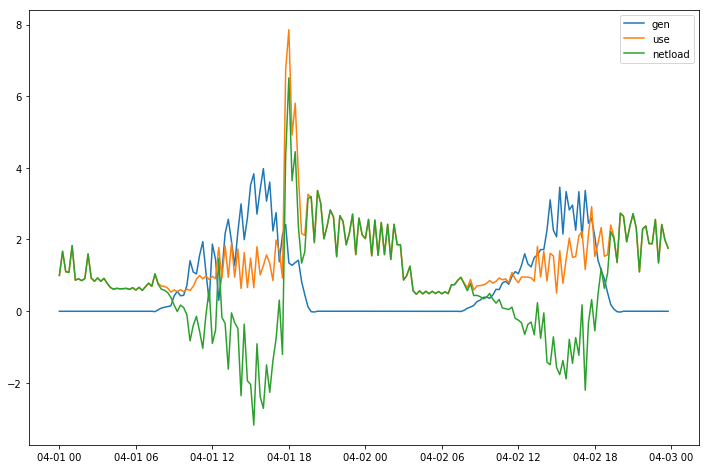

In [5]:
n_pts = 2*96
plt.figure(figsize=(12,8))
plt.plot(df['gen']['solar_home1'].iloc[:n_pts])
plt.plot(df['use']['solar_home1'].iloc[:n_pts])
plt.plot(df['netload']['solar_home1'].iloc[:n_pts])
plt.legend(['gen','use','netload'])
plt.show()

Next, we need to process this time-series data table to create the correct inputs for the disaggregation class constructor.

In [6]:
home_ids = [b + str(n+1) for b in ['solar_home', 'home'] for n in range(4)]
home_ids

['solar_home1',
 'solar_home2',
 'solar_home3',
 'solar_home4',
 'home1',
 'home2',
 'home3',
 'home4']

In [7]:
data = createSolarDisaggIndvInputs(df, home_ids, solar_proxy_ids=['solar_home1', 'solar_home2']) # we should update the bias term though, bias_term=False)
pprint.pprint(data, indent=1)

{'loadregressors': array([[1.    , 0.    , 0.    , ..., 9.41  , 0.    , 0.    ],
       [1.    , 0.    , 0.    , ..., 9.3925, 0.    , 0.    ],
       [1.    , 0.    , 0.    , ..., 9.375 , 0.    , 0.    ],
       ...,
       [0.    , 0.    , 0.    , ..., 8.62  , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 8.54  , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 8.46  , 0.    , 0.    ]]),
 'names': ['solar_home1',
           'solar_home2',
           'solar_home3',
           'solar_home4',
           'home1',
           'home2',
           'home3',
           'home4'],
 'netloads': array([[0.99813333, 0.36666667, 0.8826    , ..., 0.7212    , 1.31613333,
        0.3448    ],
       [1.67246667, 0.454     , 0.71046667, ..., 0.75286667, 1.2932    ,
        0.3164    ],
       [1.1016    , 0.43526667, 0.932     , ..., 0.60453333, 1.28246667,
        1.07173333],
       ...,
       [1.10513333, 0.74326667, 4.18586667, ..., 1.83853333, 1.33526667,
        0.429     ],
       [2

Now, we can instantiate the disaggregation class.

In [8]:
sdmod0 = SolarDisagg_IndvHome(**data)

### Case 1: Naive weights

After instantiation, all model weights are equal to one, as shown below.

In [9]:
for model in sdmod0.models.values():
    print(model['alpha'])

1
1
1
1
1
1
1
1
1


Solve the problem:

In [10]:
sdmod0.constructSolve()

2111.5284083931915

To inspect the performance, we plot actual and predicted solar output from the 8 houses.

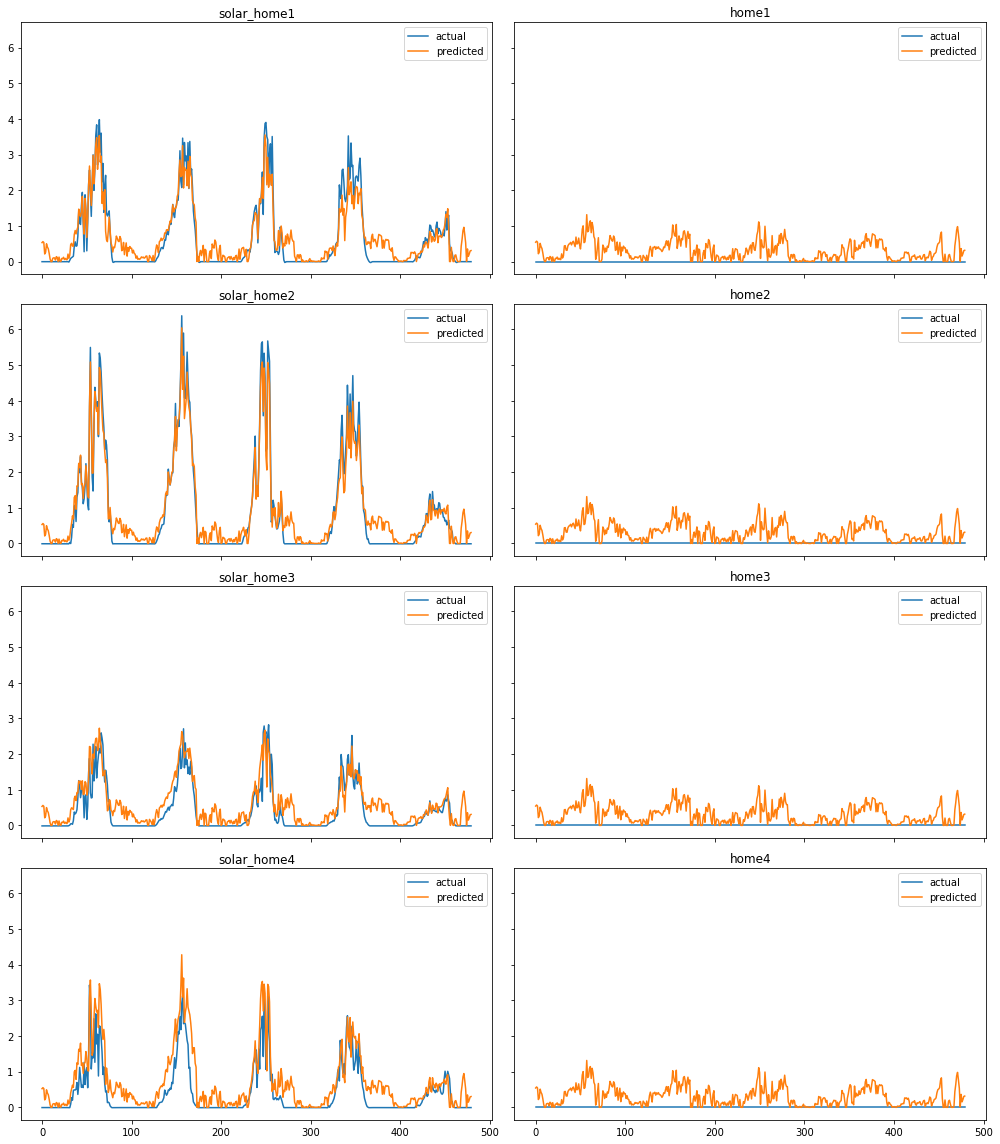

In [11]:
n_pts = 5* 96
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(14,16), sharex=True, sharey=True)
for i in range(4):
    k1 = 'solar_home{}'.format(i+1)
    k2 = 'home{}'.format(i+1)
    ax[i, 0].plot(df['gen'][k1].values[:n_pts], label='actual')
    ax[i, 0].plot(-sdmod0.models[k1]['source'].value.A1[:n_pts], label='predicted')
    ax[i, 1].plot(df['gen'][k2].values[:n_pts], label='actual')
    ax[i, 1].plot(-sdmod0.models[k2]['source'].value.A1[:n_pts], label='predicted')
    ax[i, 0].set_title(k1)
    ax[i, 1].set_title(k2)
    ax[i, 0].legend(loc=1)
    ax[i, 1].legend(loc=1)
plt.tight_layout()

Observations: This is a very bad disaggregation result. The algorithm incorrectly assigned significant generation to houses without solar and nighttime periods.

### Case 2: fancy weight tuning

In the most recent interation of the solar disaggregation work, MT included a 9-step procedure for automatically turning all the weights in the problem instance (for the load model as well as the solar models). This procedure introduces _time-dependent_ weighting, so each model has a weight for each time period in the data set.

In [12]:
for key in ['solar_home1', 'solar_home2']:
    sdmod0.addTrueValue(df['gen'][key], key)

In [13]:
sdmod0.fitTuneModels()
sdmod0.tuneAlphas()
sdmod0.constructSolve()

1.3879041321007333

Below are some plots illustrating the tuned weights

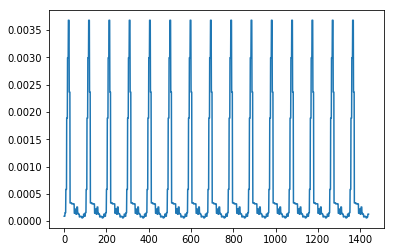

In [14]:
plt.plot(sdmod0.models['AggregateLoad']['alpha'])

### Plot the predicted vs actual solar generation

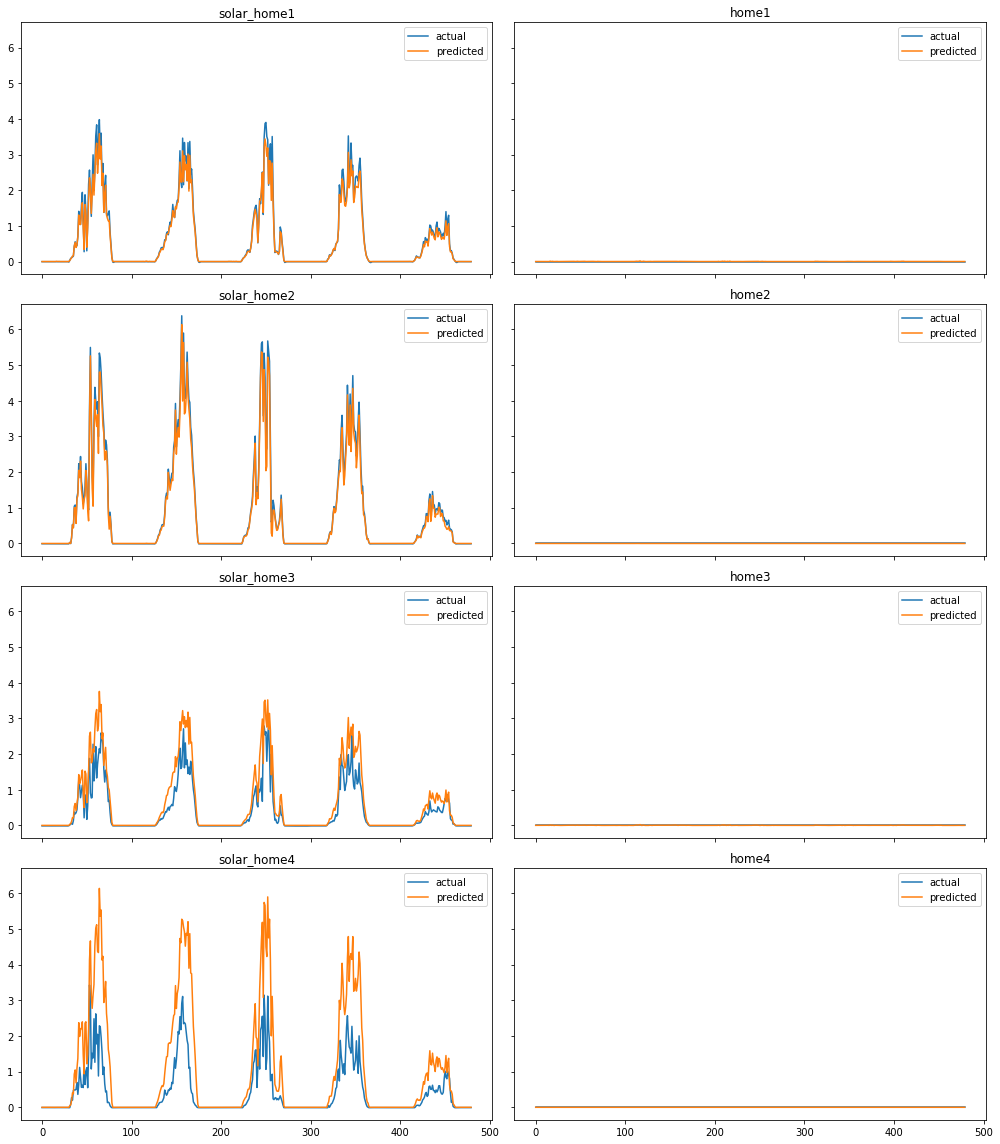

In [15]:
n_pts = 5 * 96
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(14,16), sharex=True, sharey=True)
for i in range(4):
    k1 = 'solar_home{}'.format(i+1)
    k2 = 'home{}'.format(i+1)
    ax[i, 0].plot(df['gen'][k1].values[:n_pts], label='actual')
    ax[i, 0].plot(-sdmod0.models[k1]['source'].value.A1[:n_pts], label='predicted')
    ax[i, 1].plot(df['gen'][k2].values[:n_pts], label='actual')
    ax[i, 1].plot(-sdmod0.models[k2]['source'].value.A1[:n_pts], label='predicted')
    ax[i, 0].set_title(k1)
    ax[i, 1].set_title(k2)
    ax[i, 0].legend(loc=1)
    ax[i, 1].legend(loc=1)
plt.tight_layout()

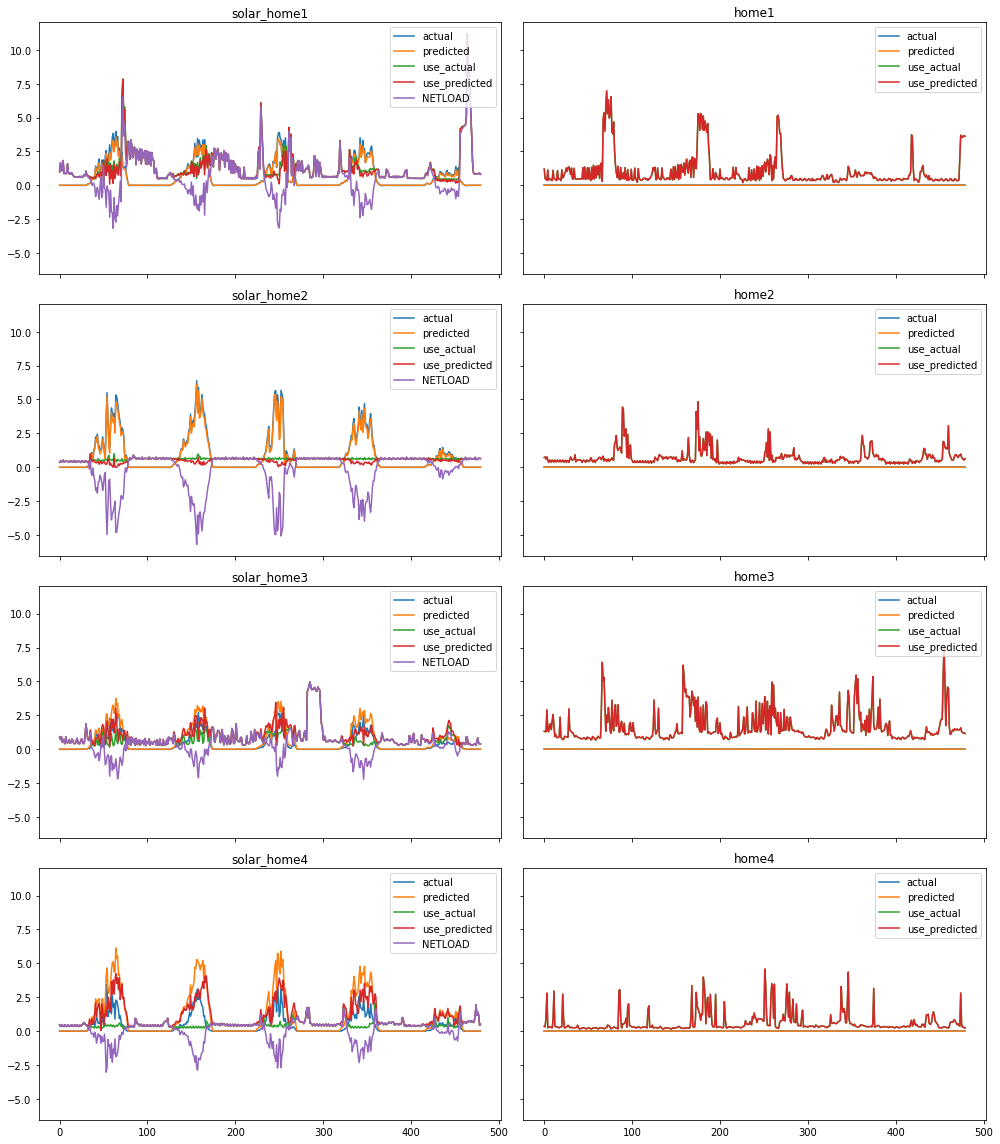

In [16]:
n_pts = 5 * 96
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(14,16), sharex=True, sharey=True)
for i in range(4):
    k1 = 'solar_home{}'.format(i+1)
    k2 = 'home{}'.format(i+1)
    ax[i, 0].plot(df['gen'][k1].values[:n_pts], label='actual')
    ax[i, 0].plot(-sdmod0.models[k1]['source'].value.A1[:n_pts], label='predicted')
    ax[i, 0].plot(df['use'][k1].values[:n_pts], label='use_actual')
    ax[i, 0].plot(-sdmod0.models[k1]['source'].value.A1[:n_pts]+df['netload'][k1].values[:n_pts], label='use_predicted')
    ax[i, 0].plot(df['netload'][k1].values[:n_pts], label='NETLOAD')
    ax[i, 1].plot(df['gen'][k2].values[:n_pts], label='actual')
    ax[i, 1].plot(-sdmod0.models[k2]['source'].value.A1[:n_pts], label='predicted')
    ax[i, 1].plot(df['use'][k2].values[:n_pts], label='use_actual')
    ax[i, 1].plot(-sdmod0.models[k2]['source'].value.A1[:n_pts]+df['netload'][k2].values[:n_pts], label='use_predicted')
    ax[i, 0].set_title(k1)
    ax[i, 1].set_title(k2)
    ax[i, 0].legend(loc=1)
    ax[i, 1].legend(loc=1)
plt.tight_layout()

Conclusion: this scenario is better than the first initialisation, assigning basically no generation to the houses without solar.
